Find me a MAinabnd

In [77]:
import sys
sys.path.append("../")

from __init__ import *
from data_tools import *
from testing import *

import keras
import tensorflow

import numpy as np
import numba
from numba import jit, prange

rng = np.random.default_rng()


In [78]:
# list of all file names in directory and subdirectories
directory = '../../../../Desktop/BatchCreatedFiles/Harmonic/'


# truth_dir = 



file_list = []
for root, dirs, files in os.walk(directory):
    for file in files:
        if file.endswith(".h5"):
            file_list.append(os.path.join(root, file))

print(len(file_list))


3713


In [79]:
print(file_list)


fft_data = []
carrier_data = []
pitch_angle_data = []

for i, file in enumerate(file_list):
    strings, attributes, attributes_values = get_attributes(file, full_path=True)
    signal = get_signal(file, strings[0])
    
    carrier_data.append(attributes_values[0][2])
    pitch_angle_data.append(attributes_values[0][5])
    
    fft = np.fft.fft(signal, norm='forward')
    
    fft_len = len(fft)
    fft = np.abs(fft[0:fft_len//2])
    
    # normalise fft for max of 1
    fft = fft / np.max(fft)
    
    fft_data.append(fft)
    
    if i % 100 == 0:
        print("Processed", i, "files")
        
print("Shape of fft_data:", np.shape(fft_data))
print("Shape of carrier_data:", np.shape(carrier_data))

['../../../../Desktop/BatchCreatedFiles/Harmonic/89.9deg_x0.00090/out_72322313-628b-49d5-98ea-30092d476c8d.h5', '../../../../Desktop/BatchCreatedFiles/Harmonic/86.9deg_x0.00405/out_5ea119f4-879b-4b81-a2a4-20b6bf0d96d5.h5', '../../../../Desktop/BatchCreatedFiles/Harmonic/87.1deg_x0.00335/out_d48a40fc-f4f9-41d1-88b1-9c84719c50c0.h5', '../../../../Desktop/BatchCreatedFiles/Harmonic/88.6deg_x0.00320/out_e1f003b5-d258-48c6-936b-3cb6c76777f4.h5', '../../../../Desktop/BatchCreatedFiles/Harmonic/87.2deg_x0.00310/out_ed6c23d8-d2c8-422d-a095-cc6ea811522e.h5', '../../../../Desktop/BatchCreatedFiles/Harmonic/88.5deg_x0.00305/out_fb425a53-8773-44c8-a7e9-2f4fd7bd66ab.h5', '../../../../Desktop/BatchCreatedFiles/Harmonic/89.6deg_x0.00195/out_9c0de879-7e39-4dc5-9be8-b0cc6f22d77a.h5', '../../../../Desktop/BatchCreatedFiles/Harmonic/86.6deg_x0.00500/out_cb4e57ab-eeee-4423-b5cf-5e29296eb595.h5', '../../../../Desktop/BatchCreatedFiles/Harmonic/90.0deg_x0.00025/out_04b05ddb-6032-4e38-8244-83ec53510e5e.h5', 

In [80]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout

def create_lightweight_cnn(input_length):
    model = Sequential()

    # First Convolutional Layer
    model.add(Conv1D(32, 3, activation='relu', input_shape=(input_length, 1)))  # 1D convolution with fewer filters
    model.add(MaxPooling1D(2))  # MaxPooling to reduce dimensionality

    # Second Convolutional Layer
    model.add(Conv1D(64, 3, activation='relu'))
    model.add(MaxPooling1D(2))

    # Flattening Layer to convert 2D to 1D
    model.add(Flatten())

    # Fully Connected Layers (with fewer neurons)
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))  # Dropout to reduce overfitting

    # Output Layer: single neuron for regression (main band frequency prediction)
    model.add(Dense(1))  # No activation function for regression

    model.compile(optimizer='adam', loss='mse', metrics=['mae'])

    return model

# Instantiate the model
model = create_lightweight_cnn(input_length=20480)
model.summary()


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_8 (Conv1D)           (None, 20478, 32)         128       
                                                                 
 max_pooling1d_8 (MaxPoolin  (None, 10239, 32)         0         
 g1D)                                                            
                                                                 
 conv1d_9 (Conv1D)           (None, 10237, 64)         6208      
                                                                 
 max_pooling1d_9 (MaxPoolin  (None, 5118, 64)          0         
 g1D)                                                            
                                                                 
 flatten_4 (Flatten)         (None, 327552)            0         
                                                                 
 dense_8 (Dense)             (None, 64)               

In [81]:
import numpy as np
from sklearn.model_selection import train_test_split

# Example: Randomly generated FFT data for demonstration (replace with actual data)
X = np.array(fft_data)  # 1000 FFT samples with length 20480
y = np.array(carrier_data)
z = np.array(pitch_angle_data)  # Random main band frequencies (example range))

# Reshaping input data to have a single channel
X = X[..., np.newaxis]

# Splitting data into training and testing sets
X_train, X_test, y_train, y_test, z_train, z_test = train_test_split(X, y, z, test_size=0.2)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape, z_train.shape, z_test.shape)

# Train the model


(2970, 20480, 1) (743, 20480, 1) (2970,) (743,) (2970,) (743,)


In [82]:
model

In [83]:
history = model.fit(X_train, y_train, epochs=100, batch_size=16, validation_data=(X_test, y_test), verbose=1)

Epoch 1/100
186/186 [==============================] - 15s 81ms/step - loss: 18930817828913152.0000 - mae: 135752624.0000 - val_loss: 15019133414408192.0000 - val_mae: 120678040.0000
Epoch 2/100
186/186 [==============================] - 14s 78ms/step - loss: 5354959855943680.0000 - mae: 59718628.0000 - val_loss: 437852286484480.0000 - val_mae: 16792626.0000
Epoch 3/100
186/186 [==============================] - 14s 78ms/step - loss: 693573464883200.0000 - mae: 21031602.0000 - val_loss: 431659715395584.0000 - val_mae: 17100216.0000
Epoch 4/100
186/186 [==============================] - 15s 78ms/step - loss: 705743523151872.0000 - mae: 21139132.0000 - val_loss: 438210547154944.0000 - val_mae: 16424440.0000
Epoch 5/100
186/186 [==============================] - 15s 78ms/step - loss: 676002149695488.0000 - mae: 20793928.0000 - val_loss: 424968693219328.0000 - val_mae: 16743057.0000
Epoch 6/100
186/186 [==============================] - 14s 77ms/step - loss: 685749712191488.0000 - mae: 210

In [49]:
# Evaluate the model
loss, mae = model.evaluate(X_test, y_test, verbose=0)

formatted_loss = "{:.4f}".format(loss)

# formate with scientific notation
formatted_mae = "{:.4e}".format(mae)

print("Mean Absolute Error:", formatted_mae)

# before 8.5887e+06

Mean Absolute Error: 1.1103e+07


24/24 [==============================] - 1s 38ms/step
Mean Absolute Error on Test Data: 5879903.865817577


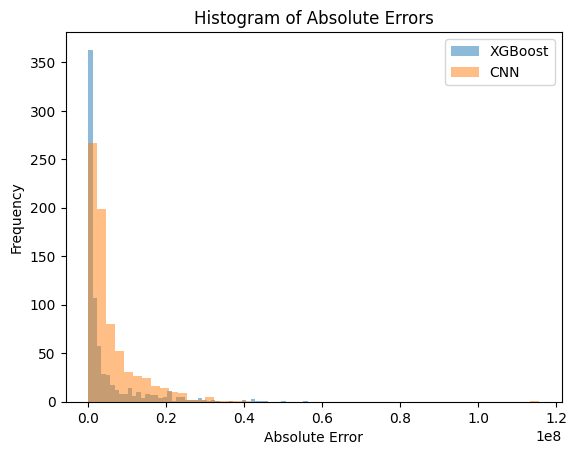

(array([ 37,  81,  84, 110, 170, 195, 226, 234, 252, 254, 285, 319, 329,
       334, 337, 362, 392, 393, 438, 453, 486, 489, 498, 502, 514, 585,
       604, 707]),)
Pitch Angle Range: 86.5 to 87.0
4/4 [==============================] - 0s 35ms/step
Mean Absolute Error: 15748142.826433592
(array([ 14,  31,  45,  96, 120, 129, 131, 151, 235, 376, 415, 504, 568,
       573, 630, 650, 664, 668, 725]),)
Pitch Angle Range: 87.0 to 87.5
3/3 [==============================] - 0s 36ms/step
Mean Absolute Error: 8048231.861105689
(array([ 49,  94, 130, 144, 160, 171, 242, 274, 279, 327, 372, 388, 405,
       422, 433, 497, 515, 517, 550, 592, 734]),)
Pitch Angle Range: 87.5 to 88.0
4/4 [==============================] - 0s 30ms/step
Mean Absolute Error: 5145179.603377771
(array([ 56,  65, 153, 159, 161, 197, 219, 301, 379, 402, 420, 428, 447,
       509, 528, 645, 686, 687, 711]),)
Pitch Angle Range: 88.0 to 88.5
3/3 [==============================] - 0s 34ms/step
Mean Absolute Error: 3317643.640

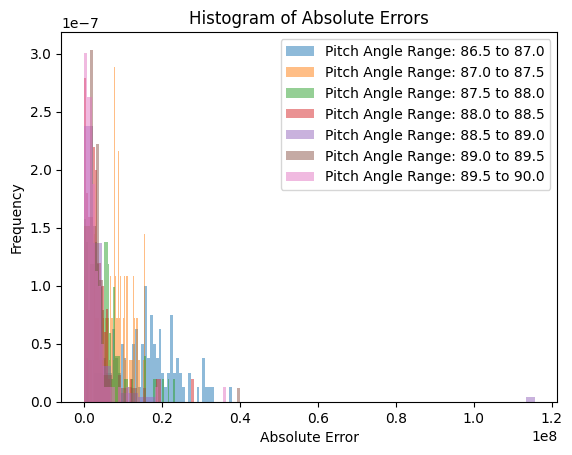

In [91]:
# predict on all test data

predictions = model.predict(X_test)

differences = np.abs(predictions.flatten() - y_test)

print("Mean Absolute Error on Test Data:", np.mean(differences))

xg_boost_hist = np.load("XGBoost_histogram_data.npy")

plt.hist(xg_boost_hist, bins=50, alpha=0.5, label="XGBoost")
plt.hist(differences, bins=50, alpha=0.5, label="CNN")
plt.legend()
plt.xlabel("Absolute Error")
plt.ylabel("Frequency")
plt.title("Histogram of Absolute Errors")
plt.show()

pitch_angle_range = np.arange(86.5, 90.5, 0.5)

# get predictions for each pitch angle range

for i in range(len(pitch_angle_range) - 1):
    lower_bound = pitch_angle_range[i]
    upper_bound = pitch_angle_range[i + 1]
    
    indices = np.where((z_test >= lower_bound) & (z_test < upper_bound))[0]
    
    lower_ind = np.where(z_test == lower_bound)
    
    print(lower_ind)
    
    if len(indices) == 0:
        continue
    
    print("Pitch Angle Range:", lower_bound, "to", upper_bound)
    
    subset_X = X_test[indices]
    subset_y = y_test[indices]
    
    predictions = model.predict(subset_X)
    
    differences = np.abs(predictions.flatten() - subset_y)
    
    print("Mean Absolute Error:", np.mean(differences))
    
    plt.hist(differences,alpha=0.5, bins=50, label="Pitch Angle Range: " + str(lower_bound) + " to " + str(upper_bound), density=True)
plt.xlabel("Absolute Error")
plt.ylabel("Frequency")
plt.title("Histogram of Absolute Errors")
plt.legend()
plt.show()
    


93/93 [==============================] - 4s 37ms/step
Mean Absolute Error on Test Data: 5632452.92712316


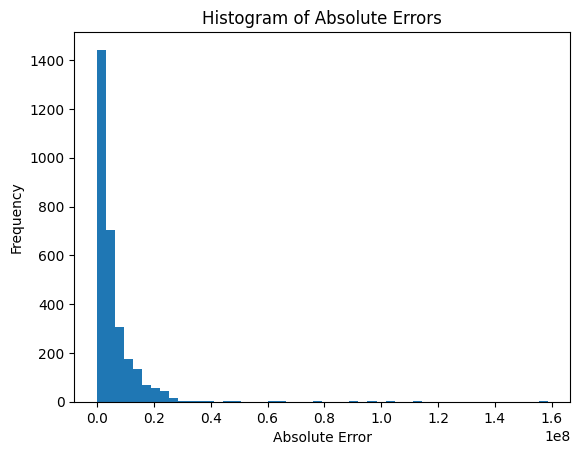

(array([  98,  156,  158,  197,  198,  214,  226,  247,  253,  260,  269,
        272,  275,  298,  335,  344,  346,  379,  391,  396,  399,  445,
        447,  448,  504,  521,  523,  548,  561,  566,  614,  617,  627,
        738,  746,  791,  834,  837,  846,  850,  856,  862,  864,  875,
        918,  976, 1011, 1029, 1061, 1091, 1102, 1118, 1123, 1181, 1183,
       1200, 1232, 1244, 1255, 1262, 1324, 1327, 1407, 1418, 1435, 1454,
       1491, 1494, 1502, 1504, 1518, 1524, 1547, 1563, 1612, 1619, 1623,
       1650, 1721, 1722, 1724, 1752, 1776, 1796, 1819, 1871, 1889, 1892,
       1920, 1937, 1952, 1959, 1974, 1976, 1990, 2002, 2039, 2041, 2048,
       2071, 2072, 2082, 2089, 2159, 2196, 2232, 2242, 2254, 2255, 2269,
       2289, 2313, 2318, 2324, 2366, 2421, 2444, 2502, 2511, 2513, 2533,
       2641, 2648, 2657, 2658, 2664, 2697, 2703, 2710, 2747, 2811, 2828,
       2877, 2887, 2889, 2892, 2899, 2955]),)
Pitch Angle Range: 86.5 to 87.0
15/15 [==============================] - 1s 3

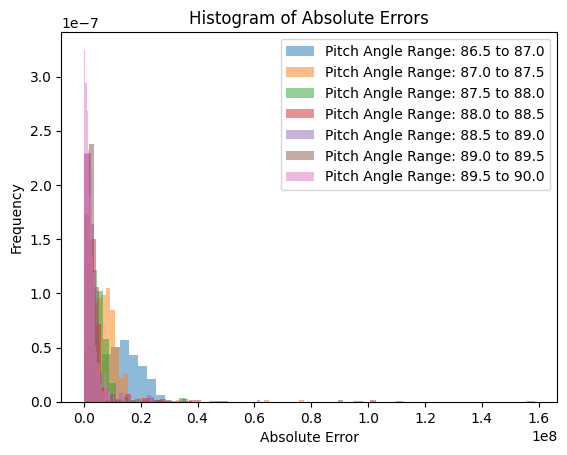

In [87]:
# predict on all test data

predictions = model.predict(X_train)

differences = np.abs(predictions.flatten() - y_train)

print("Mean Absolute Error on Test Data:", np.mean(differences))

plt.hist(differences, bins=50)
plt.xlabel("Absolute Error")
plt.ylabel("Frequency")
plt.title("Histogram of Absolute Errors")
plt.show()

pitch_angle_range = np.arange(86.5, 90.5, 0.5)

# get predictions for each pitch angle range

for i in range(len(pitch_angle_range) - 1):
    lower_bound = pitch_angle_range[i]
    upper_bound = pitch_angle_range[i + 1]
    
    indices = np.where((z_train >= lower_bound) & (z_train < upper_bound))[0]
    
    lower_ind = np.where(z_train == lower_bound)
    
    print(lower_ind)
    
    if len(indices) == 0:
        continue
    
    print("Pitch Angle Range:", lower_bound, "to", upper_bound)
    
    subset_X = X_train[indices]
    subset_y = y_train[indices]
    
    predictions = model.predict(subset_X)
    
    differences = np.abs(predictions.flatten() - subset_y)
    
    print("Mean Absolute Error:", np.mean(differences))
    
    plt.hist(differences,alpha=0.5, bins=50, label="Pitch Angle Range: " + str(lower_bound) + " to " + str(upper_bound), density=True)
plt.xlabel("Absolute Error")
plt.ylabel("Frequency")
plt.title("Histogram of Absolute Errors")
plt.legend()
plt.show()
    


24/24 [==============================] - 1s 37ms/step
Mean Absolute Error on Test Data: 5879903.865817577


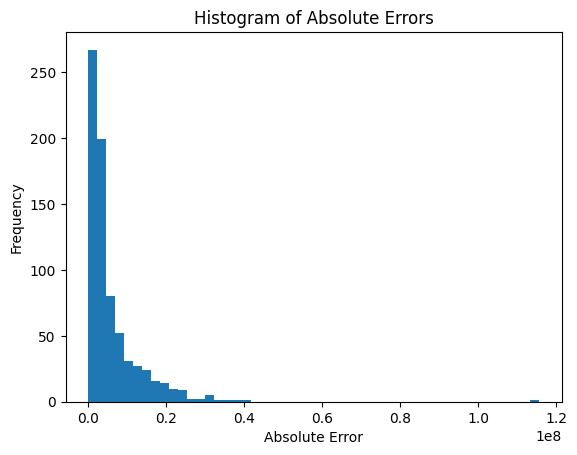

(array([  37,   77,   78,   92,  197,  217,  218,  277,  278,  305,  332,
        333,  410,  411,  459,  461,  462,  489,  510,  511,  518,  596,
        597,  634,  635,  681,  705,  718,  719,  745,  783,  820,  826,
        827,  828,  829,  830,  862,  863,  893,  938,  976,  977,  978,
        979,  980, 1027, 1028, 1104, 1117, 1118, 1133, 1154, 1155, 1193,
       1226, 1227, 1247, 1248, 1249, 1250, 1251, 1263, 1304, 1337, 1363,
       1364, 1383, 1405, 1406, 1433, 1534, 1546, 1547, 1581, 1632, 1670,
       1671, 1751, 1752, 1782, 1811, 1812, 1824, 1886, 1914, 1915, 1980,
       1981, 1993, 2029, 2030, 2105, 2106, 2148, 2205, 2234, 2235, 2254,
       2356, 2386, 2387, 2422, 2435, 2436, 2437, 2438, 2439, 2458, 2495,
       2515, 2516, 2537, 2570, 2629, 2630, 2649, 2650, 2707, 2708, 2721,
       2753, 2772, 2773, 2796, 2823, 2824, 2848, 2879, 2902, 2903, 2904,
       2905, 2906, 2912, 2942, 2943, 2980, 3031, 3032, 3045, 3083, 3090,
       3091, 3146, 3147, 3176, 3177, 3178, 3179, 3

2025-03-12 20:39:22.117930: W tensorflow/core/framework/op_kernel.cc:1828] OP_REQUIRES failed at conv_ops_fused_impl.h:761 : INVALID_ARGUMENT: convolution input must be 4-dimensional: [1,32,20480]


InvalidArgumentError: Graph execution error:

Detected at node 'sequential_4/conv1d_8/Conv1D' defined at (most recent call last):
    File "/Users/nathan/miniforge3/lib/python3.10/runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/Users/nathan/miniforge3/lib/python3.10/runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "/Users/nathan/miniforge3/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/Users/nathan/miniforge3/lib/python3.10/site-packages/traitlets/config/application.py", line 982, in launch_instance
      app.start()
    File "/Users/nathan/miniforge3/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 725, in start
      self.io_loop.start()
    File "/Users/nathan/miniforge3/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/Users/nathan/miniforge3/lib/python3.10/asyncio/base_events.py", line 600, in run_forever
      self._run_once()
    File "/Users/nathan/miniforge3/lib/python3.10/asyncio/base_events.py", line 1896, in _run_once
      handle._run()
    File "/Users/nathan/miniforge3/lib/python3.10/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/Users/nathan/miniforge3/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 513, in dispatch_queue
      await self.process_one()
    File "/Users/nathan/miniforge3/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 502, in process_one
      await dispatch(*args)
    File "/Users/nathan/miniforge3/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 409, in dispatch_shell
      await result
    File "/Users/nathan/miniforge3/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "/Users/nathan/miniforge3/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "/Users/nathan/miniforge3/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/Users/nathan/miniforge3/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 2885, in run_cell
      result = self._run_cell(
    File "/Users/nathan/miniforge3/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 2940, in _run_cell
      return runner(coro)
    File "/Users/nathan/miniforge3/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/Users/nathan/miniforge3/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3139, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/Users/nathan/miniforge3/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3318, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/Users/nathan/miniforge3/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3378, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/var/folders/cl/l2qg34px6s96_4z813158xdh0000gn/T/ipykernel_93860/2650809251.py", line 37, in <module>
      predictions = model.predict(subset_X)
    File "/Users/nathan/miniforge3/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/Users/nathan/miniforge3/lib/python3.10/site-packages/keras/src/engine/training.py", line 2554, in predict
      tmp_batch_outputs = self.predict_function(iterator)
    File "/Users/nathan/miniforge3/lib/python3.10/site-packages/keras/src/engine/training.py", line 2341, in predict_function
      return step_function(self, iterator)
    File "/Users/nathan/miniforge3/lib/python3.10/site-packages/keras/src/engine/training.py", line 2327, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/nathan/miniforge3/lib/python3.10/site-packages/keras/src/engine/training.py", line 2315, in run_step
      outputs = model.predict_step(data)
    File "/Users/nathan/miniforge3/lib/python3.10/site-packages/keras/src/engine/training.py", line 2283, in predict_step
      return self(x, training=False)
    File "/Users/nathan/miniforge3/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/Users/nathan/miniforge3/lib/python3.10/site-packages/keras/src/engine/training.py", line 569, in __call__
      return super().__call__(*args, **kwargs)
    File "/Users/nathan/miniforge3/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/Users/nathan/miniforge3/lib/python3.10/site-packages/keras/src/engine/base_layer.py", line 1150, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/Users/nathan/miniforge3/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/Users/nathan/miniforge3/lib/python3.10/site-packages/keras/src/engine/sequential.py", line 404, in call
      return super().call(inputs, training=training, mask=mask)
    File "/Users/nathan/miniforge3/lib/python3.10/site-packages/keras/src/engine/functional.py", line 512, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "/Users/nathan/miniforge3/lib/python3.10/site-packages/keras/src/engine/functional.py", line 669, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/Users/nathan/miniforge3/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/Users/nathan/miniforge3/lib/python3.10/site-packages/keras/src/engine/base_layer.py", line 1150, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/Users/nathan/miniforge3/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/Users/nathan/miniforge3/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py", line 290, in call
      outputs = self.convolution_op(inputs, self.kernel)
    File "/Users/nathan/miniforge3/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py", line 262, in convolution_op
      return tf.nn.convolution(
Node: 'sequential_4/conv1d_8/Conv1D'
convolution input must be 4-dimensional: [1,32,20480]
	 [[{{node sequential_4/conv1d_8/Conv1D}}]] [Op:__inference_predict_function_244603]

In [85]:
# predict on all test data

predictions = model.predict(X_test)

differences = np.abs(predictions.flatten() - y_test)

print("Mean Absolute Error on Test Data:", np.mean(differences))

plt.hist(differences, bins=50)
plt.xlabel("Absolute Error")
plt.ylabel("Frequency")
plt.title("Histogram of Absolute Errors")
plt.show()

pitch_angle_range = np.arange(86.5, 90.5, 0.5)

# get predictions for each pitch angle range

for i in range(len(pitch_angle_range) - 1):
    lower_bound = pitch_angle_range[i]
    upper_bound = pitch_angle_range[i + 1]
    
    indices = np.where((z >= lower_bound) & (z < upper_bound))[0]
    
    lower_ind = np.where(z == lower_bound)
    
    print(lower_ind)
    
    if len(indices) == 0:
        continue
    
    print("Pitch Angle Range:", lower_bound, "to", upper_bound)
    
    subset_X = np.array(fft_data)[indices]
    subset_y = np.array(carrier_data)[indices]
    
    predictions = model.predict(subset_X)
    
    differences = np.abs(predictions.flatten() - subset_y)
    
    print("Mean Absolute Error:", np.mean(differences))
    
    plt.hist(differences,alpha=0.5, bins=50, label="Pitch Angle Range: " + str(lower_bound) + " to " + str(upper_bound), density=True)
plt.xlabel("Absolute Error")
plt.ylabel("Frequency")
plt.title("Histogram of Absolute Errors")
plt.legend()
plt.show()
    


AttributeError: 'list' object has no attribute 'shape'

1/1 [==============================] - 0s 27ms/step
Actual: 138674266.80014038 Predicted: 136103070.0


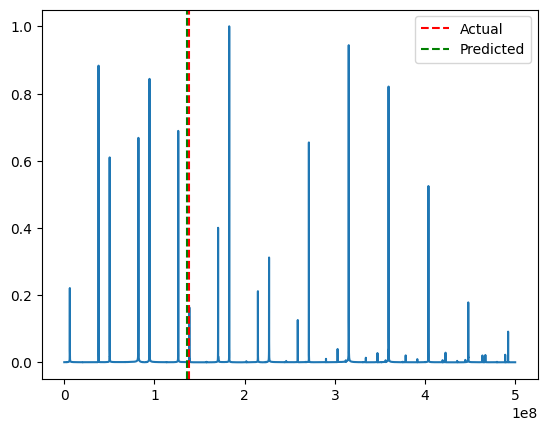

Actual: 137233375.77939987 Predicted: 147720960.0


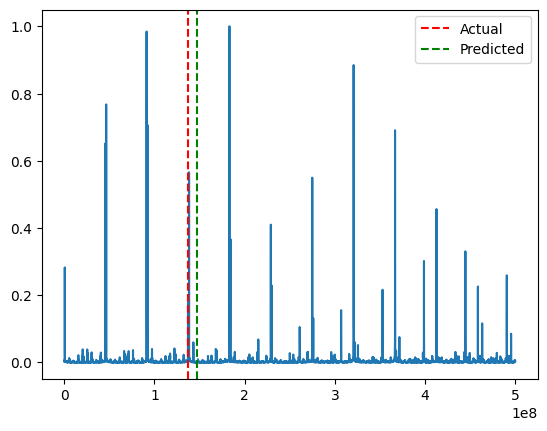

Actual: 170553514.2448082 Predicted: 148065000.0


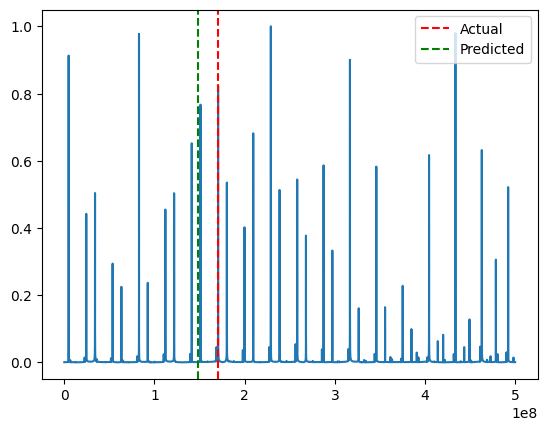

Actual: 116230747.78538895 Predicted: 126152260.0


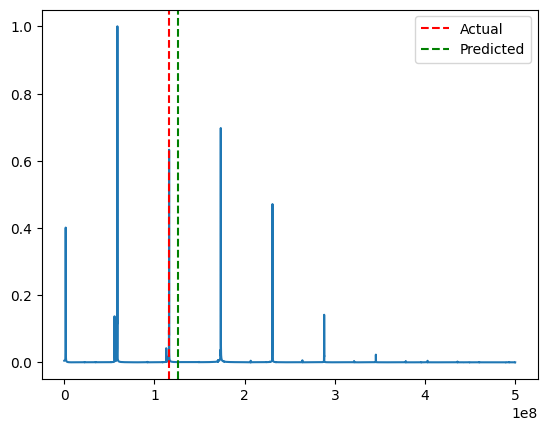

Actual: 163584121.810318 Predicted: 142989970.0


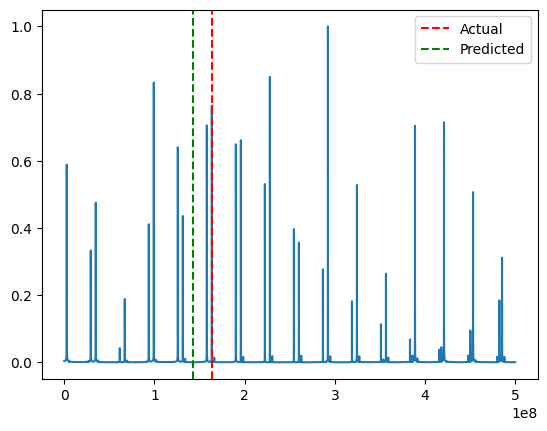

Actual: 136338092.28609085 Predicted: 133042420.0


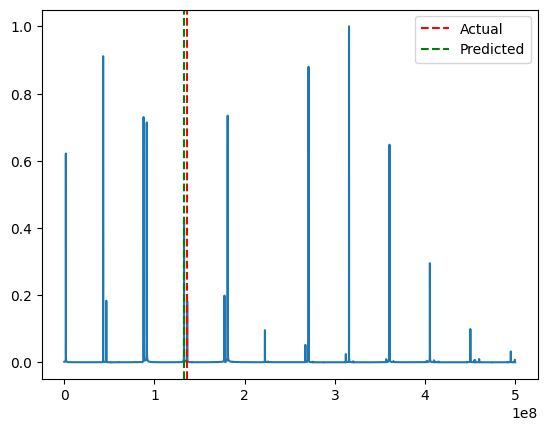

Actual: 157650082.71212387 Predicted: 139659360.0


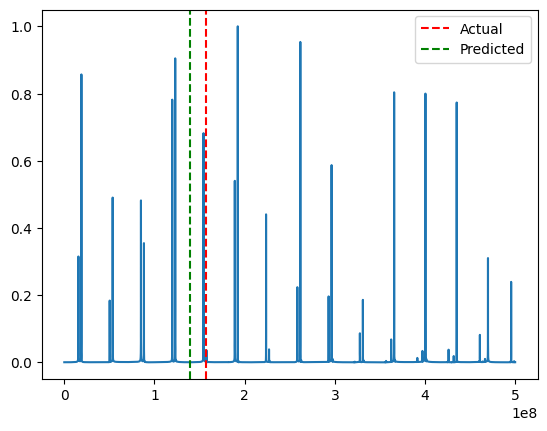

Actual: 125752661.22203827 Predicted: 127709540.0


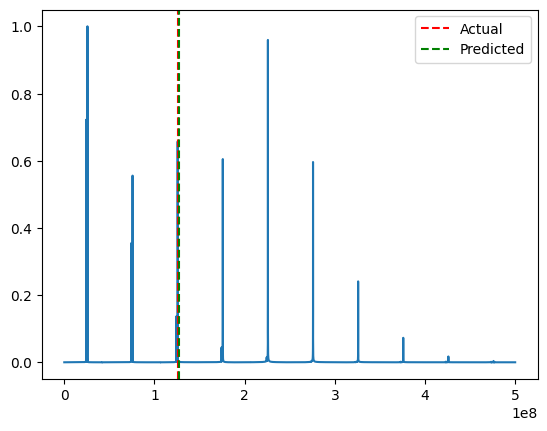

Actual: 118092864.10865021 Predicted: 125010320.0


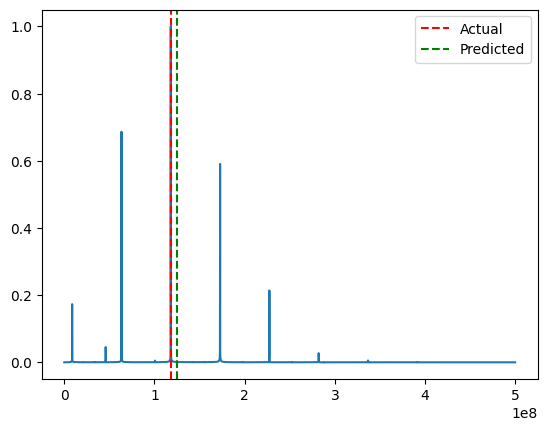

Actual: 127275574.38344193 Predicted: 132415410.0


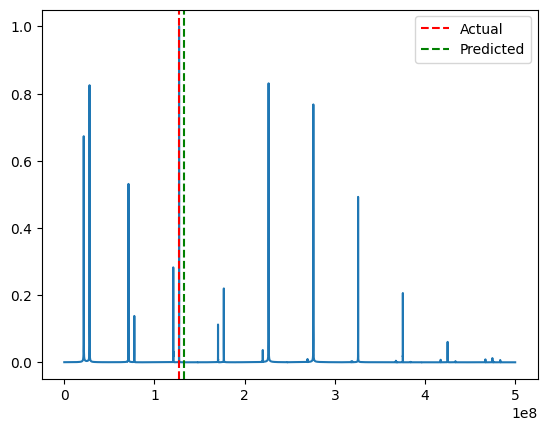

In [50]:
# evalute on specific examples to see how well it is doing from the test data 

evals = 10

# Example: Randomly selected test data for demonstration (replace with actual data)
X_example = X_test[:evals]
y_example = y_test[:evals]

# Predictions
y_pred = model.predict(X_example)

fft_freqs = np.fft.fftfreq(len(signal), 1e-9)
fft_freqs_real = fft_freqs[0:20480]

fft_freqs_real

for i in range(evals):
    print("Actual:", y_example[i], "Predicted:", y_pred[i][0])
    
    plt.plot(fft_freqs_real, X_example[i])
    plt.axvline(x=y_example[i], color='r', linestyle='--', label='Actual')
    plt.axvline(x=y_pred[i][0], color='g', linestyle='--', label='Predicted')
    plt.legend()
    plt.show()



# print(y_example) 
# print(y_pred)


Actual: 113763296.69813538 Predicted: 120548216.0


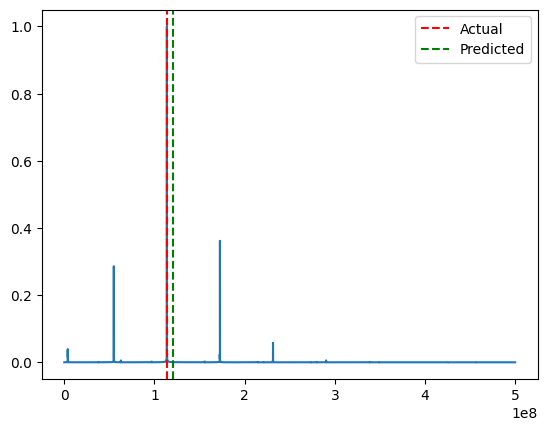

Actual: 122610979.23067093 Predicted: 122909630.0


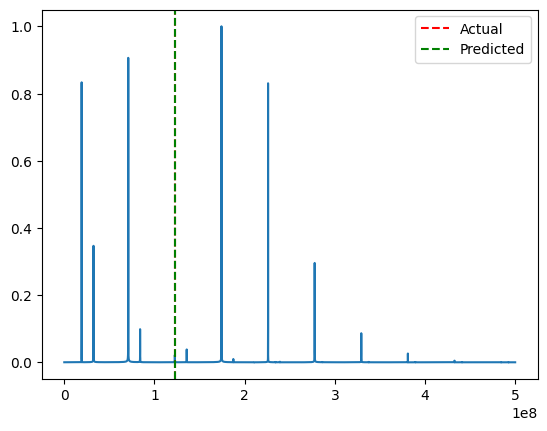

Actual: 133046324.87774658 Predicted: 135064450.0


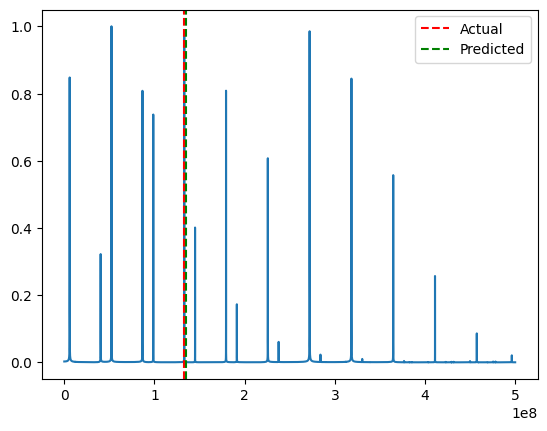

Actual: 169326172.8617592 Predicted: 152742080.0


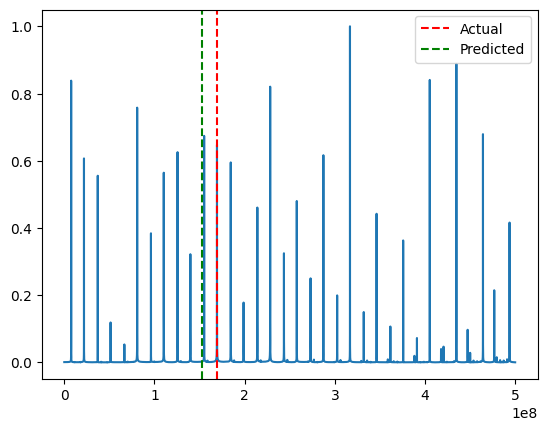

Actual: 123135163.51472855 Predicted: 124978550.0


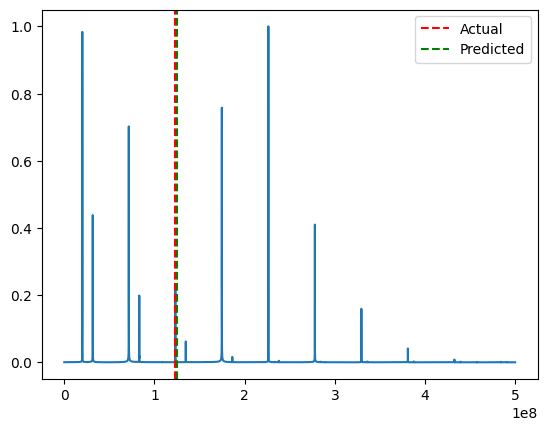

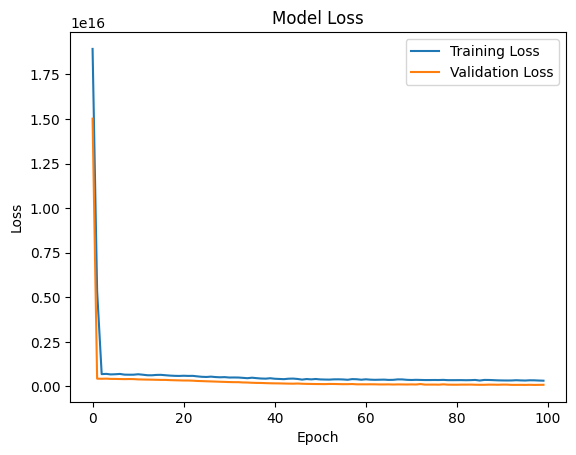

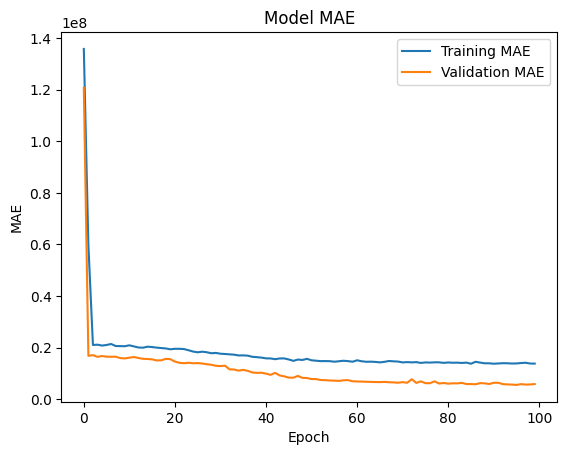

In [86]:
# plot loss and accuracy

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model MAE')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend()
plt.show()


In [76]:
model.save("harmonic_model.h5")

/Users/nathan/miniforge3/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [88]:
model.save_weights("harmonic_model2_weights.h5")
model.save("harmonic_model2.h5")

/Users/nathan/miniforge3/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [89]:
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error


# XGBoost model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, max_depth=6, learning_rate=0.1)

# Train model
xgb_model.fit(X_train, y_train)

# Predictions
y_pred = xgb_model.predict(X_test)

# Evaluate performance
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error: {mae:.2f} bins")

# Example of finding predicted peak frequency index
predicted_peak = np.round(y_pred).astype(int)


ModuleNotFoundError: No module named 'xgboost'